In [1]:
import os
os.chdir("../../")

In [2]:
import flax
from flax import linen as nn
from flax.core import unfreeze

import jax
import jax.numpy as jnp
import optax

import matplotlib.pyplot as plt
import seaborn as sns
from datasets import regression_data
import tensorflow_probability.substrates.jax as tfp

from models.gaussian_mlp import gmlp 
from models.mlp import mlp 
from utilities.fits import fit
from utilities.gmm import gmm_mean_var
from utilities.predict import predict
from utilities import plot

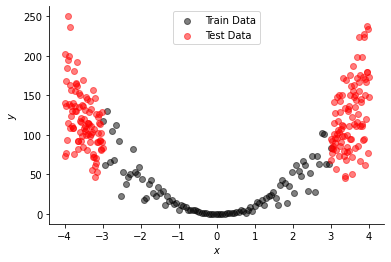

In [3]:
X,y,x_test_1,y_test_1,x_test_2,y_test_2 = regression_data.data_set(n_points=100, poly=True,hetero=True)
plot.plot_actualdata(X,y,x_test_1,y_test_1,x_test_2,y_test_2)

In [4]:
X_sorted  = jnp.sort(X[:,0]).reshape(100,1)
Y_sorted  = jnp.sort(y)
x_stack =jnp.concatenate([x_test_1,X_sorted,x_test_2],axis=0)
y_stack = jnp.concatenate([y_test_1,y,y_test_2],axis=0)

## MLP

In [5]:
mlp_model = mlp([32, 64, 32, 1],[nn.relu]*3,[0]*3)

In [6]:
mlp_params = mlp_model.init(jax.random.PRNGKey(0), X, True)

In [7]:
auxs ={
    "X": X,
    "y": y,
    "deterministic" : True
}

In [8]:
mlp_params, mlp_loss = fit(mlp_model, mlp_params, auxs, learning_rate= 0.001, epochs=1000, verbose=True)

Loss step 0:  968.0921
Loss step 100:  160.0264
Loss step 200:  143.47937
Loss step 300:  128.52245
Loss step 400:  112.14081
Loss step 500:  99.33146
Loss step 600:  93.683495
Loss step 700:  91.29189
Loss step 800:  90.12566
Loss step 900:  89.56177


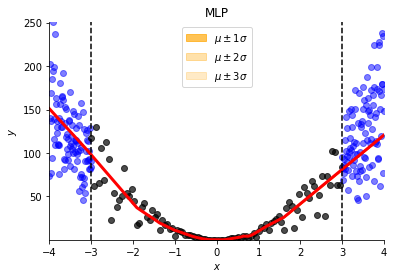

In [9]:
n_points =300
y_hat = mlp_model.apply(mlp_params, x_stack, True)
y_hat = y_hat.reshape(n_points)
plot.plot_prediction(X,y,x_stack,y_stack,y_hat,0,'MLP')

Gaussian MLP

In [10]:
gmlp_model = gmlp(features=[128, 32], activations=[nn.relu]*2, dropout_rate=[0]*2)

In [11]:
# gmlp_model.tabulate(jax.random.PRNGKey(0), X, deterministic=True)

In [12]:
gmlp_params = gmlp_model.init(jax.random.PRNGKey(1), X, True)

In [13]:
auxs ={
    "X": X,
    "y": y,
    "deterministic" : True
}

In [14]:
gmlp_params, loss = fit(gmlp_model, gmlp_params, auxs, learning_rate=0.03, epochs=1000, verbose=True)

Loss step 0:  1906.1146
Loss step 100:  4.449682
Loss step 200:  4.293592
Loss step 300:  4.033783
Loss step 400:  3.711402
Loss step 500:  3.2351446
Loss step 600:  3.1320019
Loss step 700:  3.123651
Loss step 800:  2.9415505
Loss step 900:  2.7346349


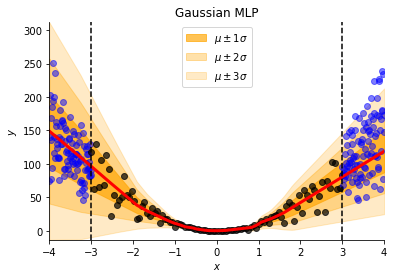

In [15]:
gmlp_mean, gmlp_sigma = gmlp_model.apply(gmlp_params, x_stack, True)
plot.plot_prediction(X, y, x_stack, y_stack, gmlp_mean, gmlp_sigma, "Gaussian MLP")

## MC Dropout Gaussian MLP

In [16]:
mc_model = gmlp(features=[32, 64, 32], activations=[nn.elu]*3, dropout_rate=[0.01]*3)

In [17]:
mc_params = mc_model.init(jax.random.PRNGKey(0), X, True)

In [18]:
mc_params, loss = fit(mc_model, mc_params, auxs, learning_rate=0.01, epochs=1000, verbose=True)

Loss step 0:  1899.2673
Loss step 100:  4.5669312
Loss step 200:  4.3169208
Loss step 300:  4.231621
Loss step 400:  4.1568027
Loss step 500:  4.0701966
Loss step 600:  3.9402473
Loss step 700:  3.722699
Loss step 800:  3.5600138
Loss step 900:  3.440537


In [19]:
n_stacks = 100
fn = lambda i : mc_model.apply(mc_params, x_stack, deterministic=False, rngs={"dropout": jax.random.PRNGKey(i)})
y_stacks = jax.vmap(fn, in_axes=(0))(jnp.arange(n_stacks))
mean_stacks = y_stacks[0]
sigma_stacks = y_stacks[1]

In [20]:
mc_mean, mc_sigma = gmm_mean_var(mean_stacks, sigma_stacks)

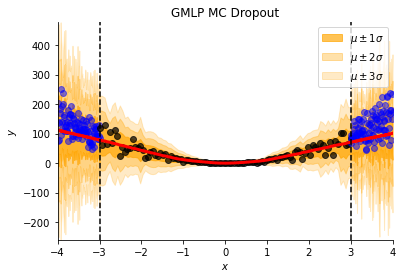

In [21]:
mc_mean, mc_sigma= mc_mean.reshape(n_points),mc_sigma.reshape(n_points)
plot.plot_prediction(X,y,x_stack,y_stack,mc_mean,mc_sigma,'GMLP MC Dropout')

## Deep Ensemble Gaussian MLP

In [22]:
auxs ={
    "X": X,
    "y": y,
    "deterministic" : True
}

In [44]:
params_list = []
losses_list = []
n_models = 3
for i in range(3):
    params = gmlp_model.init(jax.random.PRNGKey(i), auxs['X'], deterministic = True)
    params, loss =  fit(gmlp_model, params, auxs, learning_rate=0.03, epochs=1000, verbose=False)
    params_list.append(params)
    losses_list.append(loss)


In [45]:
means_list,sigmas_list = predict(n_models, gmlp_model, params_list, x_stack)
de_mean, de_sigma = gmm_mean_var(means_list,sigmas_list)

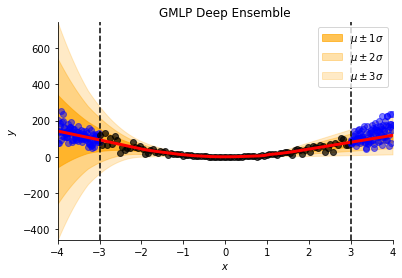

In [46]:
de_mean, de_sigma = de_mean.reshape(n_points),de_sigma.reshape(n_points)
plot.plot_prediction(X,y,x_stack,y_stack,de_mean,de_sigma,'GMLP Deep Ensemble')

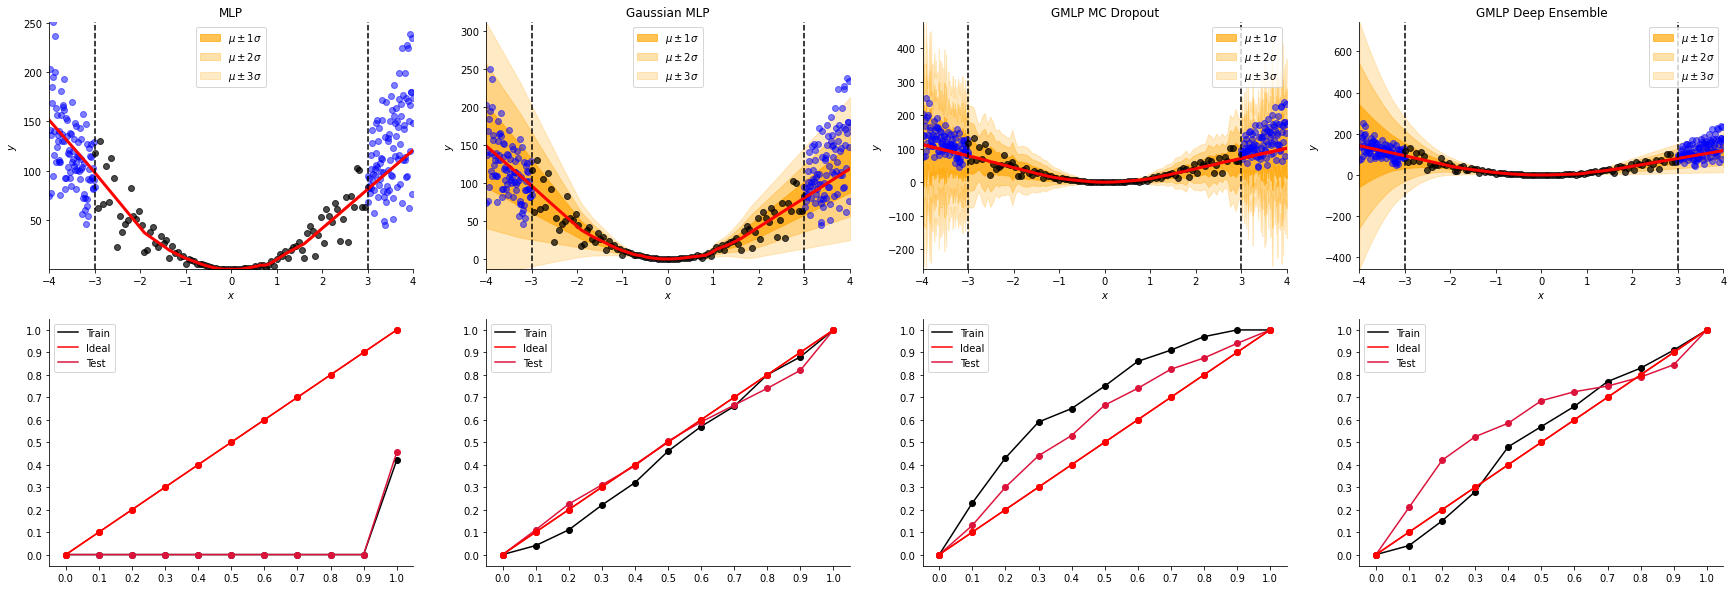

In [47]:
fig, ax = plt.subplots(2, 4, figsize=(30, 10))
plot.plot_prediction(X,y,x_stack,y_stack,y_hat,0,'MLP',ax[0][0])
plot.plot_prediction(X,y,x_stack,y_stack,gmlp_mean,gmlp_sigma,'Gaussian MLP',ax[0][1])
plot.plot_prediction(X,y,x_stack,y_stack,mc_mean,mc_sigma,'GMLP MC Dropout',ax[0][2])
plot.plot_prediction(X,y,x_stack,y_stack,de_mean,de_sigma,'GMLP Deep Ensemble',ax[0][3])
plot.calibration_reg(y_hat,jnp.zeros(300),y_stack,ax[1][0])
plot.calibration_reg(gmlp_mean,gmlp_sigma,y_stack,ax[1][1])
plot.calibration_reg(mc_mean,mc_sigma,y_stack,ax[1][2])
plot.calibration_reg(de_mean,de_sigma,y_stack,ax[1][3])
